# AI Machine Learning Practice 

# Informations

- Dataset: Music dataset

- Objectives: Classification

- Time Limits: 1 min

- Score: Classification Accuracy (Test Data)

- Please read all markdowns carefully 

- About Dataset: Music Style Data
    - 348 float type music features (frequency, tone, tempo, timbre...)
    - Label: Music Style
        - 1: Melancholy
        - 2: Romantic
        - 3: Rhythmical
    
## Various model testing code is on each practice code, 
### ./practice_code/Practice_Code_*.ipynb

## [Step 0] Importing Packages

You must specify all the packages you use in this practice in the cell below.



In [1]:
from __future__ import print_function
import os
data_path = ['data']

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.pipeline import Pipeline
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, balanced_accuracy_score, f1_score, precision_score, recall_score
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore', module='sklearn')

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## [Step 1] Read Data

Train dataset is in the 'data' directory


In [2]:
# Import the data using the file path
filepath = os.sep.join(data_path + ['music_train_data.csv'])
data = pd.read_csv(filepath)

In [3]:
data.head(1)

,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,...,f340,f341,f342,f343,f344,f345,f346,f347,f348,answer
0,-0.166614,0.284691,-0.011022,-1.028812,0.101653,0.498247,-0.314566,1.208697,-1.503008,-1.457764,...,2.136721,-1.193955,0.040614,1.127366,0.741521,-0.70773,0.077748,0.832992,-1.291423,2


In [4]:
print(data.shape)
print(data.dtypes)

(650, 349)
f1        float64
f2        float64
f3        float64
f4        float64
f5        float64
           ...   
f345      float64
f346      float64
f347      float64
f348      float64
answer      int64
Length: 349, dtype: object


In [5]:
features = data.columns[:-1]
X_data = data[features]
y_data = data['answer']

In [6]:
# Label proportion imbalanced
print(y_data.value_counts(normalize=False).sort_index())

1    336
2    240
3     74
Name: answer, dtype: int64


## [Step 2] Data Preprocessing

* Generate various preprocessing classes to use in **pipeline**
* 1. Generate class that calculates each feature columns' correlation with other columns, and transforms with droping high correlation feature columns
* 2. Generate custom classes with MinMaxScaler and StandardScaler
* 3. Generate class that for minmax scaled data, check skewing of each columns, and transforming with applying log to columns with high skew values

In [7]:
# Define class that drops column which has high correlation to other feature columns
class CorrelationDrop:
    def __init__(self, X_data):
        # List of columns to be dropped
        self.drop_col = list()
        # Correlation between every feature columns
        self.X_data_corr = pd.DataFrame(index=X_data.columns, columns=X_data.columns)
        for col in X_data.columns:
            self.X_data_corr[col] = X_data[X_data.columns].corrwith(X_data[col])
        # Make value 0 in upper triangle
        for i in range(len(self.X_data_corr.columns)):
            self.X_data_corr.iloc[i,i:] = 0.
        self.X_data_corr = self.X_data_corr.apply(abs)
        self.X_data_drop = X_data.copy()
        for col in self.X_data_corr.columns:
            for row in self.X_data_corr.index:
                if self.X_data_corr[col][row] >= 0.8:
                    self.X_data_drop.drop(columns=col, inplace=True)
                    self.drop_col.append(col)
                    break
    
    def fit(self, X_data, y_data):
        return self
    
    def transform(self, X_data):
        X_data_drop = X_data.drop(columns=self.drop_col, inplace=False)
        return X_data_drop

In [8]:
# Initialize correlation drop class variable
corrdrop = CorrelationDrop(X_data)

In [9]:
# Define custom minmax scaling class
class CustomMinmaxScaler:
    def __init__(self, X_data):
        self.msc = MinMaxScaler()
        self.msc = self.msc.fit(X_data)
    
    def fit(self, X_data, y_data=None):
        return self
    
    def transform(self, X_data):
        return pd.DataFrame(self.msc.transform(X_data), columns=X_data.columns)

In [10]:
# Initialize minmax scaling class variable
msc = CustomMinmaxScaler(X_data)
# Transform data to initialize skew class
X_data_msc = msc.transform(X_data)

In [11]:
# Define custom standard scaling class
class CustomStandardScaler:
    def __init__(self, X_data):
        self.ssc = StandardScaler()
        self.ssc = self.ssc.fit(X_data)
    
    def fit(self, X_data, y_data=None):
        return self
    
    def transform(self, X_data):
        return pd.DataFrame(self.ssc.transform(X_data), columns=X_data.columns)

In [12]:
# Initialize standard scaling class variable
ssc = CustomStandardScaler(X_data)

In [13]:
# Define class that applies log to skewed columns
class SkewLog:
    def __init__(self, X_data_msc):
        # list of columns for log to be applied
        self.skew_cols = list()
        self.skew_limit = 1.0
        self.skew_vals = X_data_msc[X_data_msc.columns].skew()

        self.skew_cols = (self.skew_vals
                          .sort_values(ascending=False)
                          .to_frame()
                          .rename(columns={0:'Skew'})
                          .query('abs(Skew) > {0}'.format(self.skew_limit))
                         )
    
    def fit(self, X_data, y_data):
        return self
    
    def transform(self, X_data_msc):
        # apply log to skewed columns
        pd.options.mode.chained_assignment = None
        X_data_msc_skew = X_data_msc.copy()
        for col in self.skew_cols.index.tolist():
            X_data_msc_skew[col] = np.log1p(X_data_msc[col])
        return X_data_msc_skew

In [14]:
# Initialize skew log class variable
skewlog = SkewLog(X_data_msc)

In [15]:
# Transform function
def transform_test(X_test_data):
    return X_test_data

## [Step 3] Model Training

* From each practice code (KNN, NB, SVM, DT(+Bagging, Forest)), select best 2 models with highest balanced_accuracy value
* Implement each model using pipeline with appropriate data preprocessing method (class)
* Combine (stack) every implemented model using voting classifier

In [16]:
# Function to calculate the % of values that were correctly predicted
def measure_error(y_true, y_pred, label=''):
    return pd.Series({'accuracy':accuracy_score(y_true, y_pred),
                      'precision': precision_score(y_true, y_pred, average='micro'),
                      'recall': recall_score(y_true, y_pred, average='micro'),
                      'balanced accuracy': balanced_accuracy_score(y_true, y_pred),
                      'f1': f1_score(y_true, y_pred, average='micro')},
                      name=label)

In [17]:
# KNN best model 1
knn1 = Pipeline([
    ('msc', msc),
    ('skewlog', skewlog),
    ('knn', KNeighborsClassifier(n_neighbors=12, p=1, weights='distance'))
])
# knn1.fit(X_data, y_data)
# y_pred = knn1.predict(X_data)
# confusion_matrix(y_true=y_data, y_pred=y_pred), measure_error(y_true=y_data, y_pred=y_pred)

In [18]:
# KNN best model 2
knn2 = Pipeline([
    ('msc', msc),
    ('knn', KNeighborsClassifier(n_neighbors=8, p=1, weights='distance'))
])
# knn2.fit(X_data, y_data)
# y_pred = knn2.predict(X_data)
# confusion_matrix(y_true=y_data, y_pred=y_pred), measure_error(y_true=y_data, y_pred=y_pred)

In [19]:
# NB best model 1
nb1 = Pipeline([
    ('msc', msc),
    ('skewlog', skewlog),
    ('gnb', GaussianNB())
])
# nb1.fit(X_data, y_data)
# y_pred = nb1.predict(X_data)
# confusion_matrix(y_true=y_data, y_pred=y_pred), measure_error(y_true=y_data, y_pred=y_pred)

In [20]:
# NB best model 2
nb2 = Pipeline([
    ('ssc', ssc),
    ('gnb', GaussianNB())
])
# nb2.fit(X_data, y_data)
# y_pred = nb2.predict(X_data)
# confusion_matrix(y_true=y_data, y_pred=y_pred), measure_error(y_true=y_data, y_pred=y_pred)

In [21]:
# SVM best model 1
svm1 = Pipeline([
    ('msc', msc),
    ('skewlog', skewlog),
    ('svc', SVC(kernel='sigmoid', C=100, gamma=0.01, probability=True))
])
# svm1.fit(X_data, y_data)
# y_pred = svm1.predict(X_data)
# confusion_matrix(y_true=y_data, y_pred=y_pred), measure_error(y_true=y_data, y_pred=y_pred)

In [22]:
# SVM best model 2
svm2 = Pipeline([
    ('msc', msc),
    ('skewlog', skewlog),
    ('svc', SVC(kernel='rbf', C=10, gamma=0.1, probability=True))
])
# svm2.fit(X_data, y_data)
# y_pred = svm2.predict(X_data)
# confusion_matrix(y_true=y_data, y_pred=y_pred), measure_error(y_true=y_data, y_pred=y_pred)

In [23]:
# DT best model 1
dt1 = DecisionTreeClassifier(max_depth=6, max_features=117)
# dt1.fit(X_data, y_data)
# y_pred = dt1.predict(X_data)
# confusion_matrix(y_true=y_data, y_pred=y_pred), measure_error(y_true=y_data, y_pred=y_pred)

In [24]:
# DT best model 2
dt2 = BaggingClassifier(n_estimators=400)
# dt2.fit(X_data, y_data)
# y_pred = dt2.predict(X_data)
# confusion_matrix(y_true=y_data, y_pred=y_pred), measure_error(y_true=y_data, y_pred=y_pred)

In [25]:
# Construct stacking voting classifier with every models defined
model = VotingClassifier([
    ('knn1', knn1),
    ('knn2', knn2),
    ('nb1', nb1),
    ('nb2', nb2),
    ('svm1', svm1),
    ('svm2', svm2),
    ('dt1', dt1),
    ('dt2', dt2)
], voting='soft')

In [26]:
# Train with whole dataset, since there are only few training data
# Each model cross validation result is in each file

model.fit(X_data, y_data)

VotingClassifier(estimators=[('knn1',
                              Pipeline(steps=[('msc',
                                               <__main__.CustomMinmaxScaler object at 0x138894d30>),
                                              ('skewlog',
                                               <__main__.SkewLog object at 0x138894c10>),
                                              ('knn',
                                               KNeighborsClassifier(n_neighbors=12,
                                                                    p=1,
                                                                    weights='distance'))])),
                             ('knn2',
                              Pipeline(steps=[('msc',
                                               <__main__.CustomMinmaxScaler object at 0x138894d30>),
                                              ('knn',
                                               KNeighborsClassifier(n_neighbor...
                                               SVC(C=100, gamma=0.01,
                                                   kernel='sigmoid',
                                                   probability=True))])),
                             ('svm2',
                              Pipeline(steps=[('msc',
                                               <__main__.CustomMinmaxScaler object at 0x138894d30>),
                                              ('skewlog',
                                               <__main__.SkewLog object at 0x138894c10>),
                                              ('svc',
                                               SVC(C=10, gamma=0.1,
                                                   probability=True))])),
                             ('dt1',
                              DecisionTreeClassifier(max_depth=6,
                                                     max_features=117)),
                             ('dt2', BaggingClassifier(n_estimators=400))],
                 voting='soft')

In [27]:
# Predict whole dataset
y_pred = model.predict(X_data)

## Check Accuracy 

* Check your Train data accuracy

In [28]:
# Calculate 
accuracy_score(y_true=y_data, y_pred=y_pred)

0.9984615384615385

## Analysis 

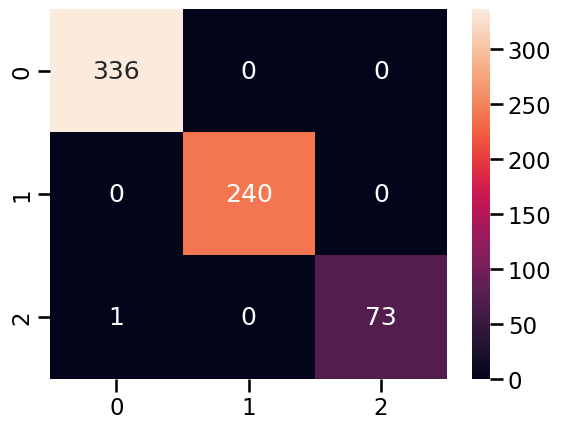

In [29]:
# Plot confusion matrix
sns.set_context('talk')
cm = confusion_matrix(y_true=y_data, y_pred=y_pred)
ax = sns.heatmap(cm, annot=True, fmt='d')

In [30]:
# Various error measures
train_test_error = pd.concat([measure_error(y_true=y_data, y_pred=y_pred)], axis=1)
train_test_error

,
accuracy,0.998462
precision,0.998462
recall,0.998462
balanced accuracy,0.995495
f1,0.998462


Since the model was trained and tested with whole training data, without splitting training and test dataset, the model has very high, almost perfect accuracy and prediction results. It may have been overfitted to training datasets, but the training dataset was too small for predicting new unseen data. So it was inevitable to utilize the whole dataset. To avoid overfitting, the model implements voting classifier, which uses stacking method, which contains various heterogeneous classification models. Each classification model was tested in each practice code, with 5-fold stratified cross validation. Each model was selected with highest balanced accuracy measure, which can properly evaluate and deal with imbalanced dataset. Balanced accuracy is defined as the average of recall obtained on each class.

# Test data

* TA will check your model's test data accuracy
* (Important) Do not change the code below

In [31]:
filepath = os.sep.join( ['data', 'music_test_data.csv'])
t_data = pd.read_csv(filepath)
features = t_data.columns
X_t_data = t_data[features]
X_t_data = transform_test(X_t_data)

y_pred = model.predict(X_t_data)
np.savetxt('out.txt', y_pred, fmt='%d', delimiter='\n')